In [2]:
# Imports and util
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import numpy as np
import re

class ImageData:

    def __init__(self, name) -> None:
        self.name = name
        self.run_dfs = {}
        self.norm_dfs = {}

## Step 1: Running energy tests
The first step to studying the performance of a workload is to run energy experiments and find energy consumption differences or hotspots. We recommend using the docker-energy framework available [here](https://github.com/enriquebarba97/docker-energy) to run these energy experiments. This fork includes some modifications to print timestamps to the logs, that we later use in analysis.

For a workload, you should create a workload folder with multiple Dockerfiles, a docker-compose.yml and a config, with varying dependencies. In our example, we changed the base image, but other dependencies can be changed.

In [14]:
workload = "redis-server"

data_path = f"data/{workload}/energy"

images = next(os.walk(data_path))[1]

print(images)

['alpinemusl@sha25625fad2a32ad1f6f510e528448ae1ec69a28ef81916a004d3629874104f8a7f70', 'light@sha25625fad2a32ad1f6f510e528448ae1ec69a28ef81916a004d3629874104f8a7f70', 'centos@sha256a1801b843b1bfaf77c501e7a6d3f709401a1e0c83863037fa3aab063a7fdb9dc', 'debian@sha25660774985572749dc3c39147d43089d53e7ce17b844eebcf619d84467160217ab', 'ubuntu@sha256b060fffe8e1561c9c3e6dea6db487b900100fc26830b9ea2ec966c151ab4c020', 'alpinejem@sha25625fad2a32ad1f6f510e528448ae1ec69a28ef81916a004d3629874104f8a7f70', 'ltrace@sha25625fad2a32ad1f6f510e528448ae1ec69a28ef81916a004d3629874104f8a7f70', 'alpine@sha25625fad2a32ad1f6f510e528448ae1ec69a28ef81916a004d3629874104f8a7f70', 'alpinepack@sha25625fad2a32ad1f6f510e528448ae1ec69a28ef81916a004d3629874104f8a7f70', 'alpineglibc@sha25625fad2a32ad1f6f510e528448ae1ec69a28ef81916a004d3629874104f8a7f70', 'ubuntupack@sha256b060fffe8e1561c9c3e6dea6db487b900100fc26830b9ea2ec966c151ab4c020', 'ubuntulibc@sha256b060fffe8e1561c9c3e6dea6db487b900100fc26830b9ea2ec966c151ab4c020']


In [15]:
# Optionally select which images to plot
toplot = ["ubuntu","alpinepack", "alpineglibc"]

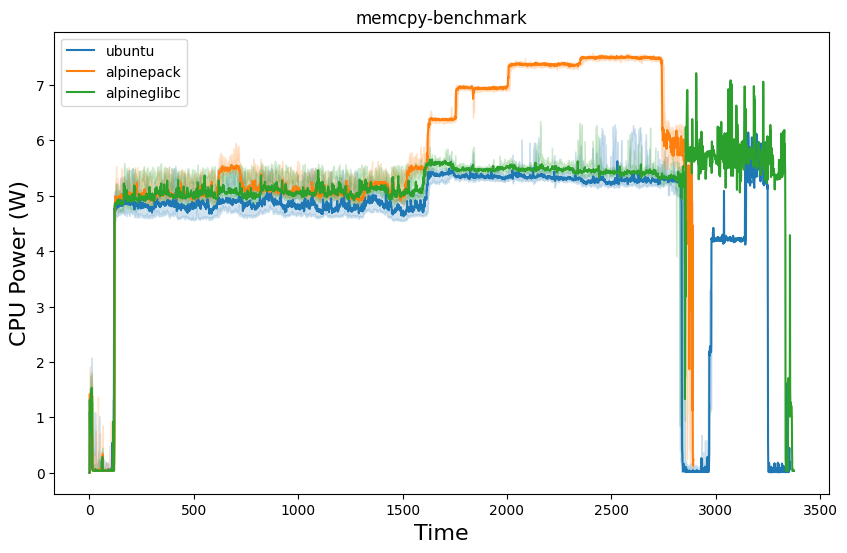

In [16]:
dataframes = {}

combined = pd.DataFrame()

fig, ax = plt.subplots(figsize=[10,6])
# ax.set_ylim(0, 10)
# ax.set_xlim(0, 3400)

data = {"Image": [], "Time (s)": [], "Energy (J)": []}

for image in images:
    image_name = image.split("@")[0]
    # if image_name not in ["light", "node", "centos","debian"]:
    if toplot is None or len(toplot)==0 or image_name in toplot:
    # if image_name in ["ubuntu", "ubuntupack", "alpinepack", "alpinemusl", "alpineglibc", "alpinejem"]:    
        dataframes[image_name] = ImageData(image_name)
        image_path = os.path.join(data_path, image)
        files = next(os.walk(image_path))[2]
        files = [f for f in files if f.endswith(".tsv")]
        dfs = {file.split(".")[0]: pd.read_csv(os.path.join(image_path, file), usecols=["Delta", "Time", "CORE0_ENERGY (J)", "USED_MEMORY", "CPU_USAGE_0"]) for file in files}
        dataframes[image_name].run_dfs = dfs

        all_data = []
        for run in dfs:
            df = dfs[run]

            key = "PACAKGE_ENERGY (W)"
            if "CPU_ENERGY (J)" in df.columns:
                key = "CPU_ENERGY (J)"
            if "CORE0_ENERGY (J)" in df.columns:
                key = "CORE0_ENERGY (J)"
            if "PACKAGE_ENERGY (J)" in df.columns:
                key = "PACKAGE_ENERGY (J)"
            if "SYSTEM_POWER (Watts)" in df.columns:
                key = "SYSTEM_POWER (Watts)"

            # Collect total energy for violin plots
            if key != "CPU_POWER (Watts)" and key != "SYSTEM_POWER (Watts)":
                df["Point"] = np.arange(df.shape[0])
                data["Image"].append(image_name)
                data["Time (s)"].append((df["Time"].iloc[-1] - df["Time"].iloc[0])/1000)
                data["Energy (J)"].append(df[key].iloc[-1] - df[key].iloc[0])

            # Compute power and plot
            energy = df[key].copy().to_list()
            cpu_data = df["CPU_USAGE_0"].copy().to_list()
            memory_data = df["USED_MEMORY"].copy().to_list()
            
            current_data = []

            if key != "CPU_POWER (Watts)" and key != "SYSTEM_POWER (Watts)":
                df[key + "_original"] = df[key].copy()
                for i in range(0, len(energy)):
                    if i in df[key + "_original"] and i - 1 in df[key + "_original"]:
                        # diff with previous value and convert to watts
                        energy[i] = (energy[i] - df[key + "_original"][i - 1]) * (1000 / df["Delta"][i])
                    else:
                        energy[i] = 0
                # data = data[1:-1]
                for i in range(0, len(energy)):
                    current_data.append({"Time": i, "CPU_POWER (Watts)": energy[i], "CPU_USAGE_0": cpu_data[i], "USED_MEMORY": memory_data[i]})
                    all_data.append({"Time": i, "CPU_POWER (Watts)": energy[i], "CPU_USAGE_0": cpu_data[i], "USED_MEMORY": memory_data[i]})
        
            dataframes[image_name].norm_dfs[run] = pd.DataFrame(current_data)
        
        all_data = pd.DataFrame(all_data)
        dataframes[image_name].norm_dfs["median"] = all_data.groupby("Time").median().reset_index()
        
        plot = sns.lineplot(all_data, x="Time", y="CPU_POWER (Watts)", estimator=np.median,errorbar=lambda x: (np.quantile(x, 0.25), np.quantile(x, 0.75)), ax=ax, legend=True, label=image_name)
        ax.set_xlabel("Time", size=16) 
        ax.set_ylabel("CPU Power (W)", size=16)
        plot.set_title("memcpy-benchmark")

plt.show()

In [12]:
aggregate = pd.DataFrame(data)

aggregate.groupby("Image").describe(include="all")

Time (s)                                                        
               count        mean        std      min        25%       50%   
Image                                                                       
alpineglibc     30.0  284.163933  10.206018  278.949  281.24900  282.3990  \
alpinepack      30.0  286.535233   1.347058  284.152  285.57500  286.4015   
ubuntu          30.0  295.271433   7.954821  288.177  293.12575  294.1805   

                                Energy (J)                           
                   75%      max      count         mean        std   
Image                                                                
alpineglibc  283.47725  337.589       30.0  1435.277323  24.093821  \
alpinepack   287.40500  289.353       30.0  1651.107956  15.555502   
ubuntu       295.57650  335.701       30.0  1401.535518  32.811963   

                                                                              
                     min          25%          50%          75%          max  
Image                                                                         
alpineglibc  1395.170670  1422.231220  1436.256866  1446.272015  1527.899826  
alpinepack   1622.637558  1644.226643  1650.471428  1657.752132  1702.232361  
ubuntu       1340.059143  1382.077553  1399.722046  1419.141323  1481.168533

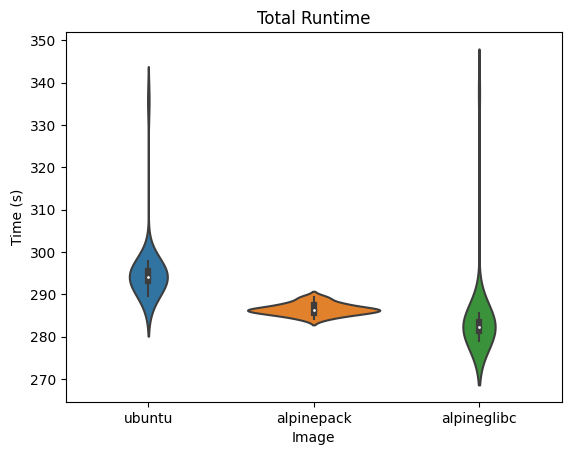

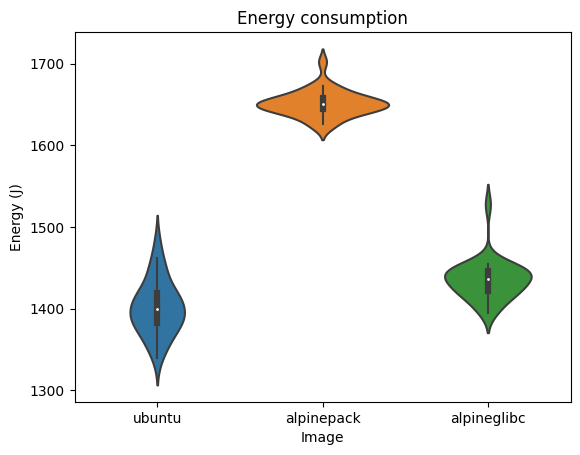

In [13]:
sns.violinplot(x="Image", y="Time (s)", data=aggregate)
plt.title("Total Runtime")
plt.show()

sns.violinplot(x="Image", y="Energy (J)", data=aggregate)
plt.title("Energy consumption")
plt.show()

## Step 2: Tracing with uftrace
The next step is to run the workload with *uftrace*. For this, it is recommended again to use docker. One of the Dockerfiles from the previous step can be reused by adding the installation steps of *uftrace* before the rest of the setup.

It is important to use the *ts* tool from [moreutils](https://joeyh.name/code/moreutils/) to have timestamps in the log that are consistent with the logs from docker-energy.

An example with redis is included in `docker/redis-traced`. You can use this as a template for your own tracing experiment. To run, use:

```
docker compose -f docker/redis-traced/docker-compose.yml build
docker compose -f docker/redis-traced/docker-compose.yml up --abort-on-container-exit 2>&1 | ts %.s > ./data/redis-server/logs/traced.txt
```

This will create the tracing data folder and the log file to use later during analysis

# Step 3: Data analysis
You can use the newly generated uftrace data folder to analyze some of the aspects of the workload execution. For example